In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score

from sklearn.ensemble import IsolationForest

from PIL import Image

In [ ]:
labeled_data = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/train.csv')
unlabeled_data = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/oob.csv')

In [ ]:
def img_show(path, ratio=0.7):
    img = Image.open(path)
    w,h = img.size
    img1 = img.resize((int(w*ratio), int(h*ratio)))
    return img1

# Isolation Forest

## Isolation Forest 소개

### Isolation Forest의 아이디어

- Few and Different : 비정상 범주에 속하는 데이터는 그 **숫자가 적을 것**이며 다수의 정상 데이터와 비교했을 때 **매우 다른 특징**을 보일 것임

- 기존 tree algorithm과 비교
    - 유사점 : 트리 구조는 개별 개체를 효과적으로 고립시키는데 활용될 수 있음
        - Novel Instances : 트리의 root 부분에 가까울 것으로 기대됨, 즉 빠르게 고립이 될 것 (작은 path length)
        - Normal Instances : tree의 깊은 말단 부분에서 고립될 것으로 기대됨, 즉 여러번 고립을 시켜야 될 것 (큰 path length)

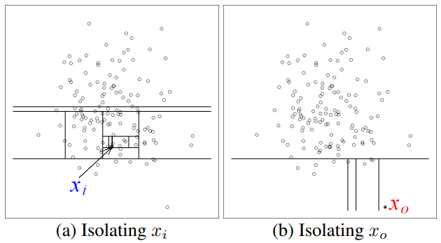

In [ ]:
# Image.open('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_1.png')
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_1.png')


- 차이점 : 기존 tree algorithm들은 분할 기준을 y값(클래스)의 불순도를 낮추는 방향으로 지정
    - Isolation Forest는 비지도 학습으로 y값이 아닌 랜덤(임의로)하게 분할 진행
    - 분할 기준이 될 변수와 값을 랜덤하게 선택
        - 초기에는 path length(anomaly score)의 변동이 크지만 일정 반복 횟수를 넘어서게 되면 특정 값으로 수렴

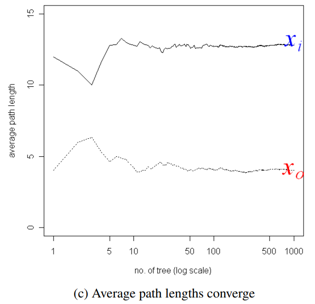

In [ ]:
# Image.open('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_2.png')
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_2.png', ratio=0.5)

### Isolation Tree 알고리즘

- 트리 형태의 isolation 결과는 novel instances를 발견하는데 활용할 수 있으며, 이를 위해서 터미널 노드까지의 평균 path length를 novelty score(anomaly score)로 활용하게 됨

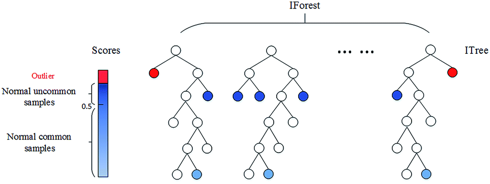

In [ ]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/isolationforest.png', ratio=0.5)

- Isolation Tree(iTree):
    - n개의 개체들 중에서 X의 샘플이 주어진다면 X에 대해서 랜덤하게 선택된 속성 q와 분할값 p를 가지고 재귀적으로 분할을 시도하게 됨
    - 종료 조건:
        - 1) 트리가 height limit에 도달했을 때 (hlim은 하이퍼파라미터)
        - 2) 모든 X에 대해서 isolate시켰을 때
        - 3) 모든 X 개체들이 같은 값을 가지고 있을 때(더 이상 분할 불가 상태)
- Path Length :
    - path length h(x)는 x가 root 노드부터 termial 노드까지 도달하는데 거쳐간 edge의 수 (이때 edge는 그래프의 edge)
    - h(x)는 평균 path length인 c(n)에 의해 정규화됨
        - h(x)는 모든 path length를 구해 평균을 구하지 않더라도 아래 수식과 같이 근사적으로 빠르게 얻을 수 있음
        - H(i) = ln(i) + 0.5772156649(Euler's constant)
    

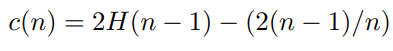

In [ ]:
Image.open('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_3.png')

- Novelty score:
    - novelty score에 해당하는 s(x,n)의 지수 부분을 분해해 보면
        - E(h(x)) : 1개의 tree에 대해 x를 isolation 시키기 위해 필요한 path length의 기대값
        - c(n) : 평균 path length

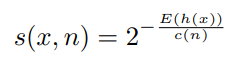

In [ ]:
Image.open('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_4.png')

- Novelty Score 해석
- 아래와 같이 novelty score는 0~1사이의 값으로 normalize되어 출력됨
    - 1) E(h(x))가 c(n)과 같은 경우 : 지수가 -1이기 때문에 score는 0.5, path lenth가 평균적인 수준
    - 2) E(h(x))가 0에 수렴하는 경우 : 지수가 0이기 때문에 score는 1에 가까워짐, isolation이 빠르게 되는 경우 이므로 비정상으로 구분
    - 3) E(h(x))가 n-1 즉, 끝까지 도달하는 경우 : 지수가 무한대에 가까워지기 때문에 score는 0으로 수렴, 즉 isolation되기까지 많은 분할이 필요 정상 범주로 구분  

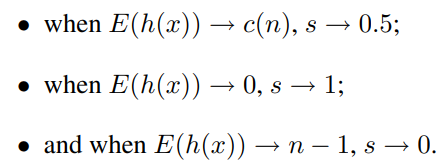

In [ ]:
Image.open('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_5.png')

- Scikitlearn IsolationForest 예시

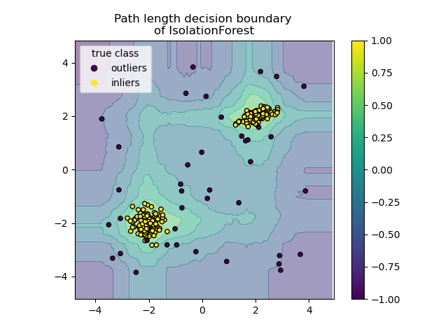

In [ ]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/isolationforest_sklearn.png')

### Subsampling
- 데이터의 수가 많을 경우 모든 데이터를 사용해 tree를 만들게 되면 계산 복잡도가 높아짐
- IsolationForest는 모든 데이터를 사용하지 않고 일부 샘플만 subsampling하여 tree를 만들어냄
- sampling을 계속 반복할 경우 sampling 결과가 모집단 분포에 근사할 수 있기 때문에 성능은 향상시키면서 전체 데이터를 사용했을 때와 결과에 큰 차이가 없을 것으로 보임

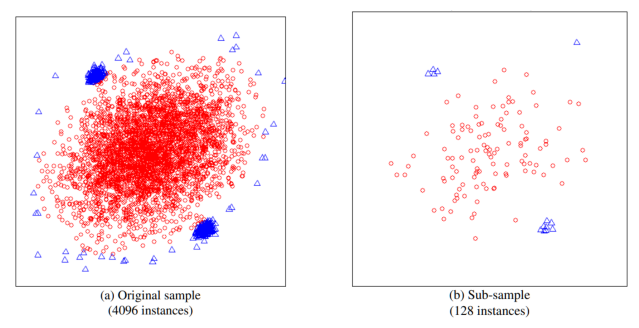

In [ ]:
import cv2
img1 = cv2.imread('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_6.png')
img2 = cv2.imread('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_171805_7.png')

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.show()

### Extended Isolation Forests
- 일반적인 Isolation Forest는 분할을 수직 또는 수평적으로 수행하기 때문에 anomaly score map을 그려보았을 때 매우 편향적이고 결합이 있는 경우들이 있음
- 따라서, 수직/수평이 아닌 기울기가 있는 일차식으로서 분할을 수행하여 이러한 한계를 극복하는 것이 아이디어

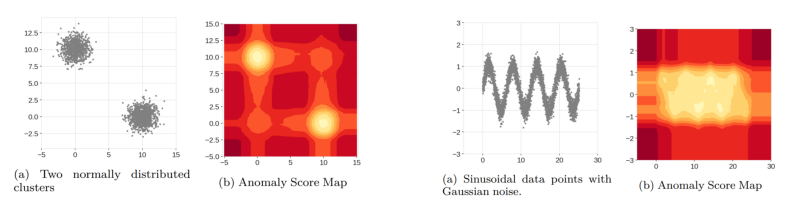

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_185514_1.png')
img2 = cv2.imread('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_185514_2.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.show()

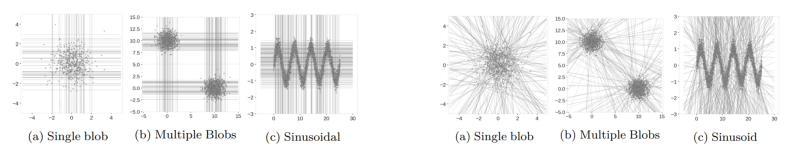

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_185514_3.png')
img2 = cv2.imread('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_185514_4.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.show()

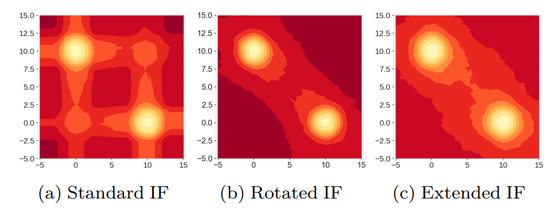

In [ ]:
img_show('/content/drive/MyDrive/ASAC3기_이상탐지/Code/6주차/이승용/image/20231210_185514_5.png', ratio = 0.5)

### Isolation Forest 예시

In [ ]:
trainX = labeled_data.iloc[:, :-1]
trainY = labeled_data.iloc[:, -1]

In [ ]:
trainX['time'] = pd.to_datetime(trainX['date'].astype(str) + trainX['hour'].astype(str), format='%Y%m%d%H')

In [ ]:
trainX.fillna(method='ffill', inplace=True)

## 상태 변수 변환(rolling=24h)
출처 : [기간이동 계산 (rolling)](https://wikidocs.net/152788)
- 직전 24시간 평균치로 상태변수로 변환
- rolling 파라미터
    
    - `window` : 계산할 창(window)의 크기, 열 기준으로 계산할 경우 행의 수, 여기서는 24로 설정
    
    - `center` : {True / False} 레이블을 window의 중간에 둘지 여부입니다. 기본값은 False로 레이블이 창 우측에 위치합니다. 현재는 False로 지정(오른쪽)

    - `win_type` : {'triang' / 'gaussian' / ...} 가중치를 넣어 계산할 경우 계산 방식, 연산 메서드에 추가 인수를 지정해야할 수도 있음
        - 가중치 연산에 대한 정보 : [Window functions](https://docs.scipy.org/doc/scipy/reference/signal.windows.html#module-scipy.signal.windows)
        - <font color=yellow>필요하다면 가중이동평균 산식을 적용해서 조금 더 가까운 시간의 정보를 반영하는 평균으로 변환</font>

    - `on` : 시계열 인덱스나, 시계열과 유사한 열이 있을 경우 이 열을 기준으로 rolling을 수행
    - `axis` : 계산의 기준이 될 축, 여기서는 `axis=1`
    - `closed` : {'left' / 'right' / 'both' / 'neither'} window가 닫히는 방향, 여기서는 기본값 right 지정

In [ ]:
trainX.columns

Index(['ckey', 'machine_id', 'date', 'hour', 'connect_avg', 'connect_max',
       'in_handover_rate', 'out_handover_rate', 'inter_handover_rate',
       'lower_prb', 'upper_prb', 'reconfig_rate', 'time'],
      dtype='object')

In [ ]:
target_columns = ['connect_avg', 'connect_max',
                  'in_handover_rate', 'out_handover_rate', 'inter_handover_rate',
                  'lower_prb', 'upper_prb', 'reconfig_rate']

In [ ]:
static_data = pd.DataFrame()
for i in range(3):
    tmp = trainX.iloc[i*1464:(i+1)*1464, 4:][target_columns].rolling(24).mean()
    static_data = pd.concat([static_data, tmp])

In [ ]:
static_data = static_data.fillna(method='bfill')

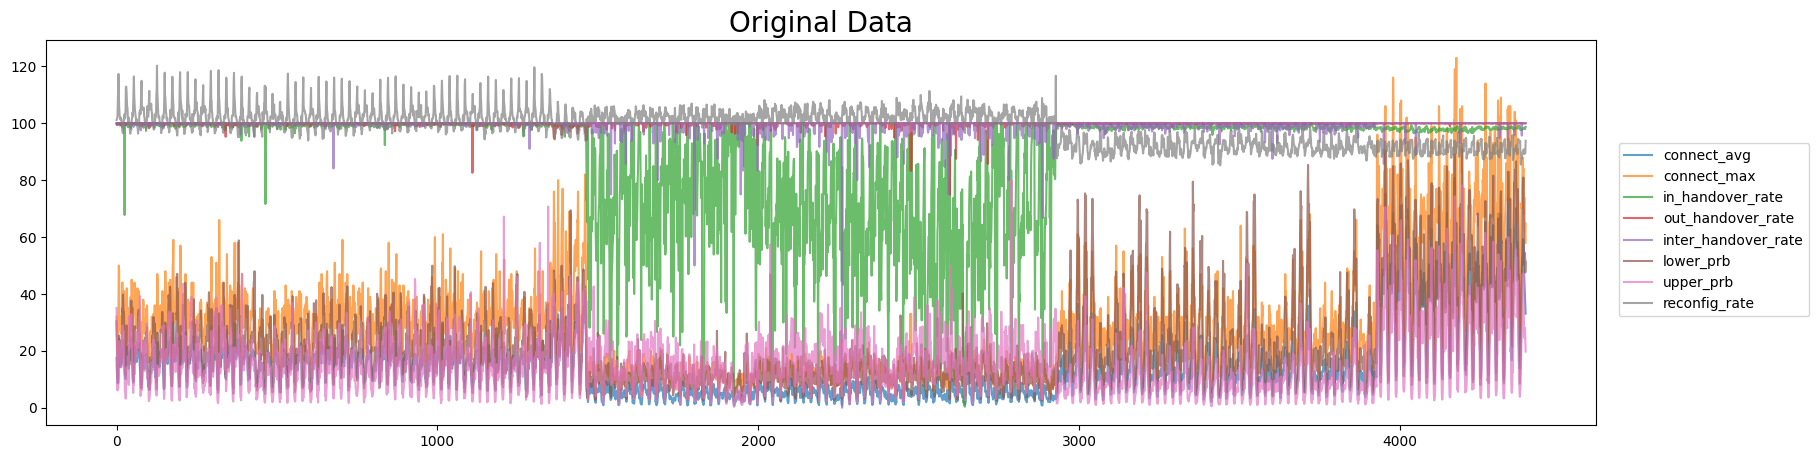

In [ ]:
trainX[target_columns].plot(kind='line', figsize=(20, 5), alpha=0.7)
plt.title('Original Data', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
plt.show()

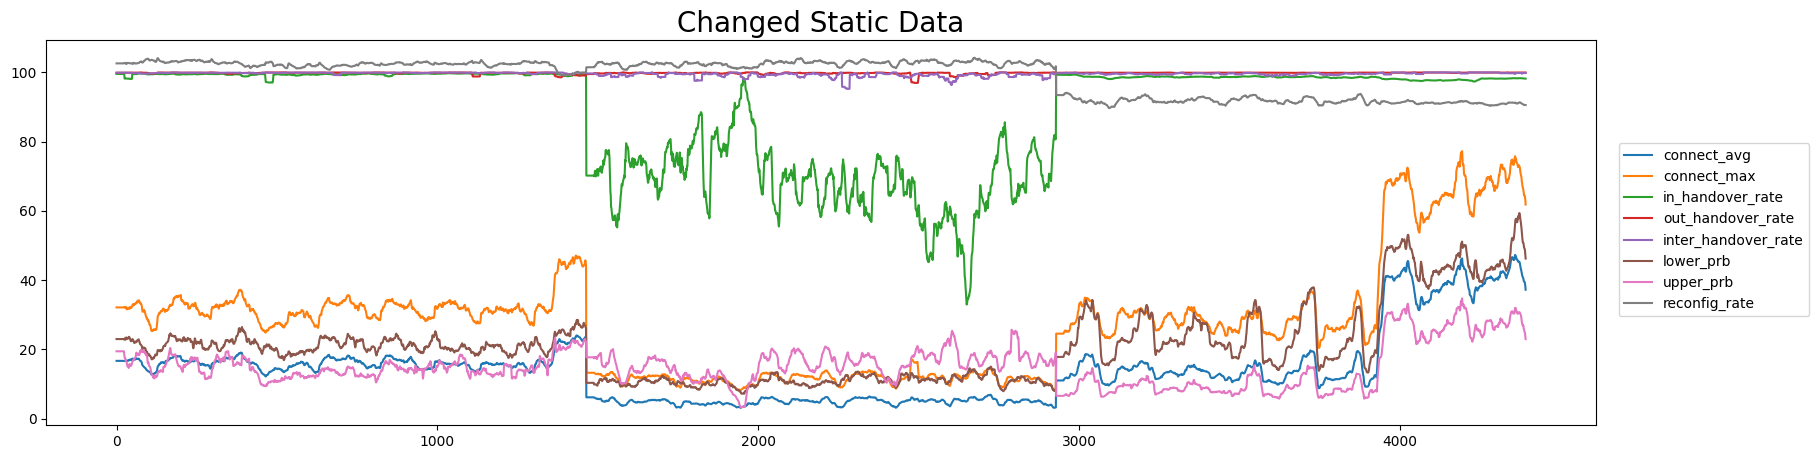

In [ ]:
static_data.plot(kind='line', figsize=(20, 5))
plt.title('Changed Static Data', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
plt.show()

In [ ]:
static_data.sample()

,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate
751,16.500301,32.083333,99.478774,99.925355,99.897345,22.199511,12.315816,102.047061


## 스케일링(선택적)

In [ ]:
X_train = static_data.copy()
y_train = trainY.copy()

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

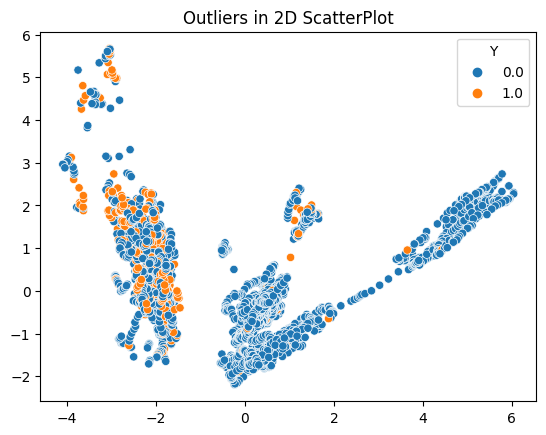

In [ ]:
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=trainY)
plt.title("Outliers in 2D ScatterPlot")
plt.show()

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

In [ ]:
df = pd.DataFrame()
df['label'] = trainY
df['machine_id'] = trainX['machine_id']
df['tsne_x'] = X_train_tsne[:,0]
df['tsne_y'] = X_train_tsne[:,1]
df['tsne_z'] = X_train_tsne[:,2]
df['anomalies'] = np.where(df['label'] ==1, 'Anomaly', 'Normal')

In [ ]:
# df['anomalies'] = np.where(df['mahalanobis_dist'] >= mahala_dist_99, 'Anomaly', 'Normal')

fig = px.scatter_3d(df, x='tsne_x', y='tsne_y', z='tsne_z', color='machine_id', symbol='anomalies',
                    opacity=0.4)
fig.update_layout(width=1000, height=500, margin_l=20, margin_r=20,
                    margin_b=20, margin_t=20, legend_yanchor="top", legend_y=0.99,
                    legend_xanchor="left", legend_x=0.01)
fig.update_traces(marker_size = 5)
fig.show()

In [ ]:
fig = px.scatter_3d(df, x='tsne_x', y='tsne_y', z='tsne_z', color='anomalies', symbol='label',
                    opacity=0.7)
fig.update_layout(width=1000, height=500, margin_l=20, margin_r=20,
                    margin_b=20, margin_t=20, legend_yanchor="top", legend_y=0.99,
                    legend_xanchor="left", legend_x=0.01)
fig.update_traces(marker_size = 2)
fig.show()

## 모델 fit

In [ ]:
clf = IsolationForest(max_samples=200, random_state=0)
clf.fit(X_train)

IsolationForest(max_samples=200, random_state=0)

- 각 샘플에 대한 Anomaly Score
- IsolationForest 객체에서는 논문과는 다르게 음수값의 anomaly score를 출력
- 따라서, 반대로 수치가 작을수록 비정상(anomaly)에 해당한다고 볼 수 있음
- IsolationForest() 인자인 offset으로 정상, 비정상의 임계치(기준)을 조정할 수 있음

In [ ]:
anomaly_score = -np.sort(clf.score_samples(X_train))

In [ ]:
anomaly_score

array([0.64998496, 0.6446365 , 0.64092818, ..., 0.3760448 , 0.37563013,
       0.3750769 ])

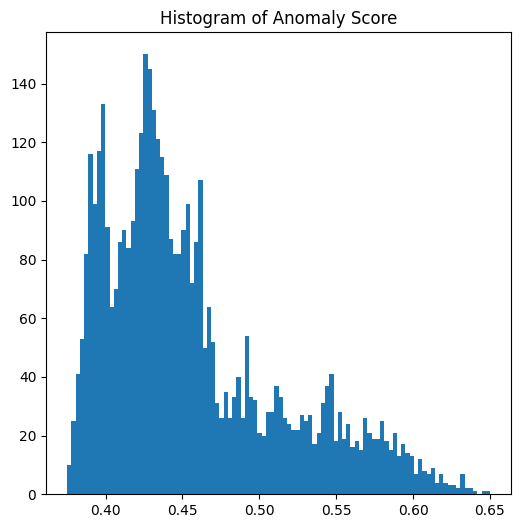

In [ ]:
plt.figure(figsize=(6,6))
plt.hist(anomaly_score, bins=100)
plt.title("Histogram of Anomaly Score")
# sns.kdeplot(anomaly_score)
plt.show()

In [ ]:
train_pred = np.where(clf.predict(X_train)==1, 0, 1)

In [ ]:
print('Isolation Accuracy score :', accuracy_score(y_train, train_pred).round(4))
print('Isolation F1 score :', f1_score(y_train, train_pred).round(4))

Isolation Accuracy score : 0.7115
Isolation F1 score : 0.157


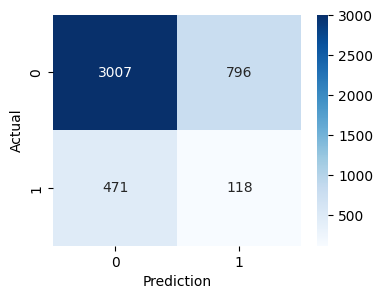

In [ ]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_train, train_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

## Extended Isolation Forest (보류)

## 결과 시각화

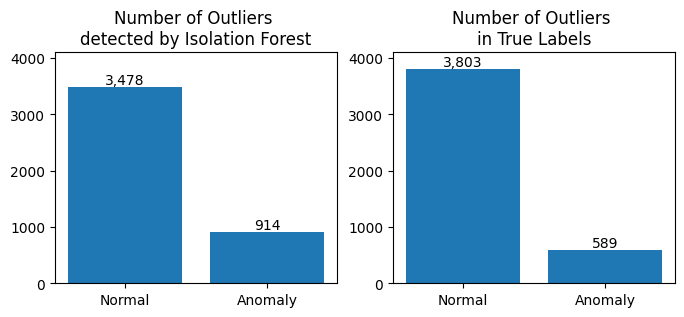

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,3))

label, count = np.unique(train_pred, return_counts=True)

axs[0].set_title('Number of Outliers \ndetected by Isolation Forest')
bar_container = axs[0].bar(label, count)
axs[0].bar_label(bar_container, fmt='{:,.0f}')
axs[0].set_ylim((0,4100))
axs[0].set_xticks(ticks=label, labels=['Normal', 'Anomaly'])

label, count = np.unique(trainY, return_counts=True)

axs[1].set_title('Number of Outliers \nin True Labels')
bar_container = axs[1].bar(label, count)
axs[1].bar_label(bar_container, fmt='{:,.0f}')
axs[1].set_ylim((0,4100))
axs[1].set_xticks(ticks=[0,1], labels=['Normal', 'Anomaly'])
plt.show()

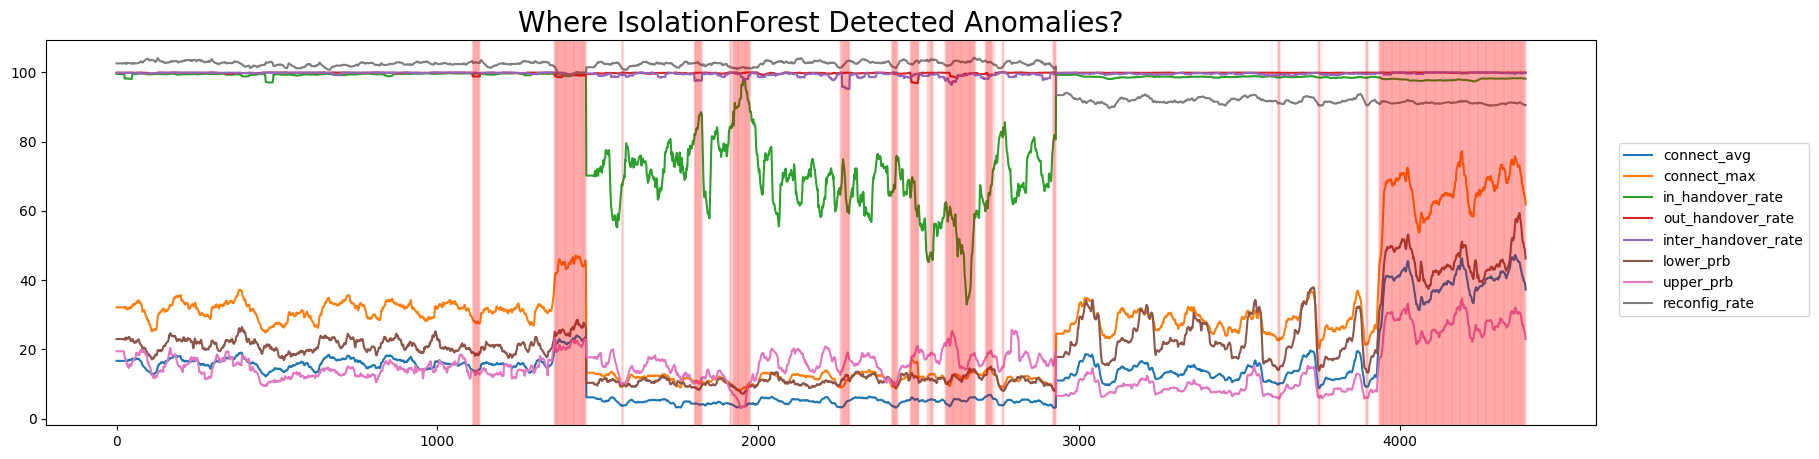

In [ ]:
static_data.plot(kind='line', figsize=(20, 5))
plt.title('Where IsolationForest Detected Anomalies?', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
for idx in np.argwhere(train_pred == 1):
    plt.axvline(x=idx, color='r', linestyle='-', alpha=0.06)
plt.show()

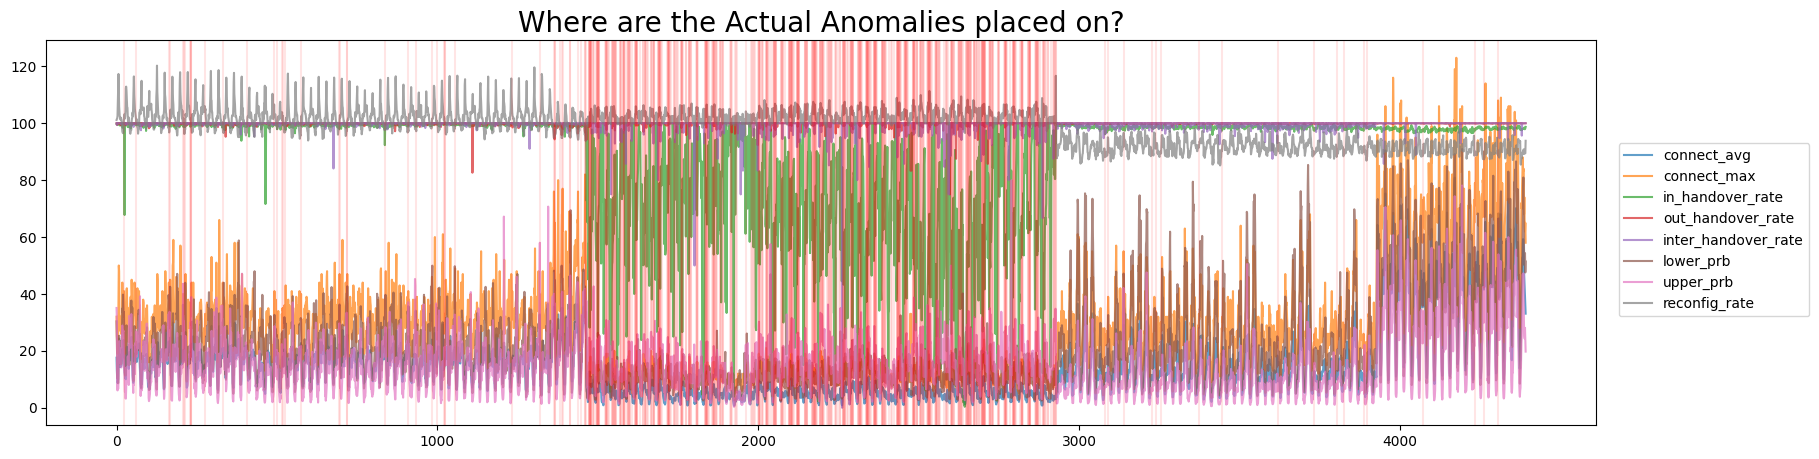

In [ ]:
trainX[target_columns].plot(kind='line', figsize=(20, 5), alpha=0.7)
plt.title('Where are the Actual Anomalies placed on?', fontsize=20)
plt.legend(bbox_to_anchor=(1.01,0.75))
for idx in np.argwhere(y_train.values == 1):
    plt.axvline(x=idx, color='r', linestyle='-', alpha=0.1)
plt.show()

In [ ]:
def find_anomalies_machine(df:str, machine_id:str, target_columns=target_columns):
    tmp = df.loc[df.machine_id == machine_id][target_columns].rolling(24).mean()
    tmp.fillna(method='bfill', inplace = True)
    tmp.reset_index(drop=True, inplace = True)
    # display(tmp)
    clf = IsolationForest(max_samples=200, random_state=0)
    clf.fit(tmp)

    train_pred = np.where(clf.predict(tmp)==1, 0, 1)

    tmp.plot(kind='line', figsize=(18, 3))
    plt.title(f'Point of Anomalies in {machine_id}', fontsize=20)
    plt.legend(bbox_to_anchor=(1.01,0.75))
    for idx in np.argwhere(train_pred == 1):
        plt.axvline(x=idx, color='r', linestyle='-', alpha=0.1)
    plt.show()

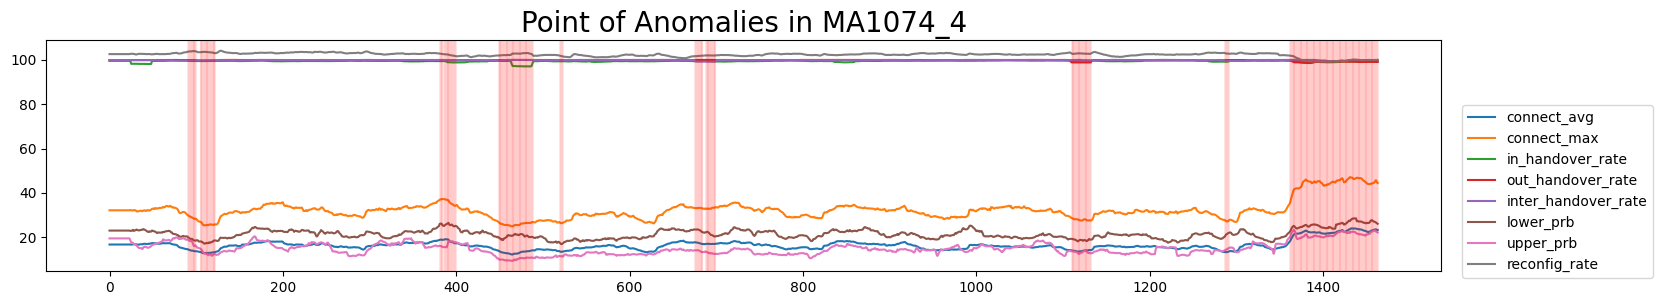

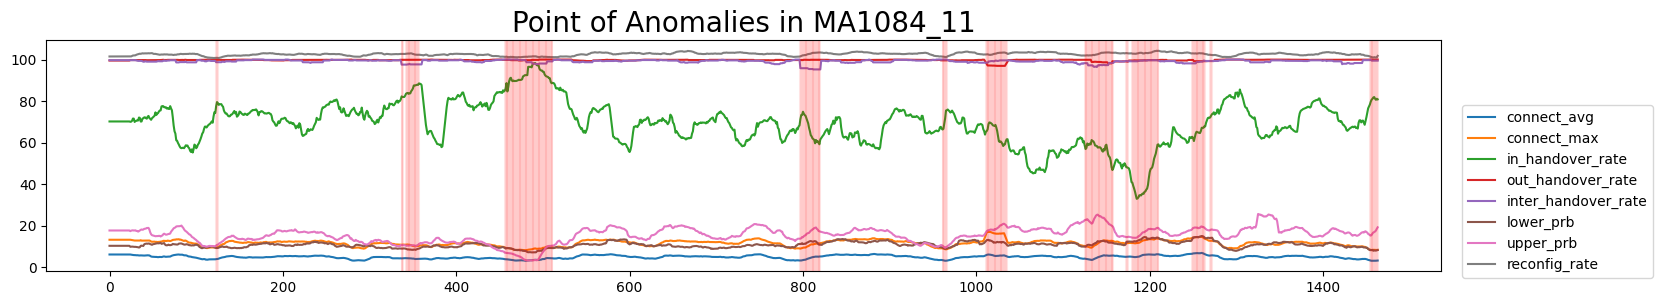

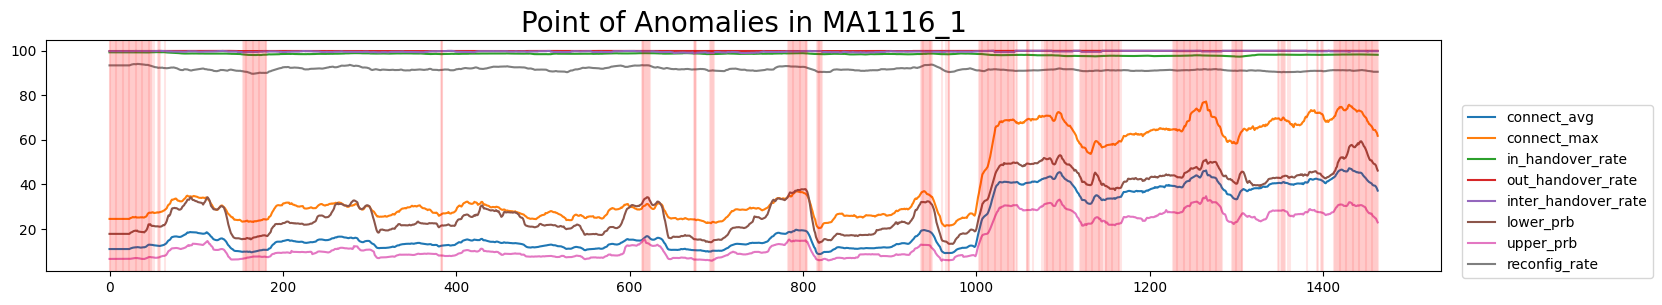

In [ ]:
for machine_id in list(trainX.machine_id.unique()):
    find_anomalies_machine(df=trainX, machine_id = machine_id)

## OOB 테스트

In [ ]:
oob = pd.read_csv('/content/drive/MyDrive/ASAC3기_이상탐지/Code/5주차/이승용/oob.csv')

In [ ]:
oob.head()

,ckey,machine_id,date,hour,connect_avg,connect_max,in_handover_rate,out_handover_rate,inter_handover_rate,lower_prb,upper_prb,reconfig_rate
0,MA1004_0-20210901-0,MA1004_0,20210901,0,27.913285,43.0,97.523220,100.000000,100.0,45.402603,59.021408,100.409763
1,MA1004_0-20210901-1,MA1004_0,20210901,1,23.013333,36.0,98.170732,NaN,100.0,36.740540,21.128778,99.953052
2,MA1004_0-20210901-2,MA1004_0,20210901,2,22.158977,38.0,98.039216,98.765432,100.0,28.568421,15.338933,100.249377
3,MA1004_0-20210901-3,MA1004_0,20210901,3,18.396667,34.0,98.717949,100.000000,100.0,16.503713,8.009815,100.512821
4,MA1004_0-20210901-4,MA1004_0,20210901,4,14.173889,28.0,97.014925,100.000000,100.0,14.133542,5.109716,99.923136


In [ ]:
oob['time'] = pd.to_datetime(oob['date'].astype(str) + oob['hour'].astype(str), format='%Y%m%d%H')

In [ ]:
oob.fillna(method='ffill', inplace=True)

In [ ]:
for machine_id in list(oob.machine_id.unique()):
    find_anomalies_machine(df=oob, machine_id = machine_id)

Output hidden; open in https://colab.research.google.com to view.